# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

In [500]:
import numpy as np
import os
#from scipy.misc import imread, imresize  # I am trying skimage.io and skimage.transformed 
import datetime
import os
import matplotlib.pyplot as plt

from skimage.io import imread
from skimage.transform import resize as imresize

#from scipy.misc.pilutil import imread, imresize
#from PIL import Image, ImageFilter, ImageEnhance

We set the random seed so that the results don't vary drastically.

In [501]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
#tf.set_random_seed(30)
tf.random.set_seed(30)

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [502]:
train_doc = np.random.permutation(open('Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('Project_data//val.csv').readlines())
batch_size = 16 #experiment with the batch size

In [503]:
#Checking if the files is been read properly or not
#train_doc
print("Number of training Doc : ",len(train_doc))

#val_doc
print("Number of validation Doc : ", len(val_doc))

#img_idx = #create a list of image numbers you want to use for a particular video
#img_idx = [5,10,20,25]
#img_idx = [1,3,5,7,9,11,13,15,17,19,21,23,25,27]
#img_idx = [0,4,8,12,16,20,24,28]

# selecting alternate frames from 1 to 28.
seq_idx = range(1,28,3)
#print(len(img_idx))

image_height = 64
image_width = 64

Number of training Doc :  663
Number of validation Doc :  100


In [504]:
imresize?

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [505]:
def generator(source_path, folder_list, batch_size):
    print( '\nSource path = ', source_path, '; batch size =', batch_size)
    #img_idx = #create a list of image numbers you want to use for a particular video
    
    img_idx = seq_idx #[0,4,8,12,16,20,24,28] #[1,3,5,7,9,11,13,15,17,19,21,23,25,27]  #[5,10,20,25] # taken 14 image [0,4,8,12,16,20,24,28]
    while True:
        t = np.random.permutation(folder_list)
        #num_batches = # calculate the number of batches
        num_batches = int(len(folder_list)/batch_size) # casting to integer
        #num_batches = len(folder_list)/batch_size # casting to integer
        #print("I am here in 1st loop ")
        for batch in range(num_batches): # we iterate over the number of batches
            #batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            #batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            
            batch_data = np.zeros((batch_size,len(img_idx),image_height,image_width,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            
            #print("I am here in 2nd loop ")
            for folder in range(batch_size): # iterate over the batch_size
                #print("Batch Size : ",batch_size)
                #print(batch*batch_size)
                #print
                #print("Source path : ",source_path)
                #print(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0])
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                #print("Images :",imgs)
                #print("I am here in 3rd loop ")
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    #print("idx :", idx)
                    #print("item : ", item)
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    #print("Before Resize :" ,image)
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    #image = image.resize(64,64)
                    #print("height :", image_height)
                    #print("width :", image_width)
                    #image = image.resize(image_height,image_width)
                    
                    
                    image = imresize(image,(image_height,image_width))
                    
                    #print("After Resize : " ,image)
                    #print("Folder : ", folder)
                    #print("idx : ", idx)
                    #print("Batch Data 0 : ",batch_data[folder,idx,:,:,0] )
                    #print("Batch Data 1 : ",batch_data[folder,idx,:,:,1] )
                    #print("Batch Data 2 : ",batch_data[folder,idx,:,:,2] )
                    
                    #batch_data[folder,idx,:,:,0] /= 255   #normalise and feed in the image
                    #batch_data[folder,idx,:,:,1] /= 255   #normalise and feed in the image
                    #batch_data[folder,idx,:,:,2] /= 255   #normalise and feed in the image
                    
                    batch_data[folder,idx,:,:,0] = image[:,:,0]/255   #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = image[:,:,1]/255   #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = image[:,:,2]/255   #normalise and feed in the image
                    
                    #batch_data[folder,idx,:,:,0] 
                    #batch_data[folder,idx,:,:,1]
                    #batch_data[folder,idx,:,:,2]
                    #print(batch_data)
                    
    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            #print("I am yielding")
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do
            
        # write the code for the remaining data points which are left after full batches
        #print("\nI am at end of batch run. Need to pick left iver")
        #print(len(t))
        remaining_folders = len(t)%batch_size
        #print(remaining_folders)
        batch += 1
        if remaining_folders != 0 :
            batch_data = np.zeros((remaining_folders,len(img_idx),image_height,image_width,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((remaining_folders,5)) # batch_labels is the one hot representation of the output
            
            for folder in range(remaining_folders): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    #image = image.resize(image_height,image_width)
                    image = imresize(image,(image_height,image_width))
                    
                    #batch_data[folder,idx,:,:,0] /= 255   #normalise and feed in the image
                    #batch_data[folder,idx,:,:,1] /= 255   #normalise and feed in the image
                    #batch_data[folder,idx,:,:,2] /= 255   #normalise and feed in the image
                    
                    batch_data[folder,idx,:,:,0] = image[:,:,0]/255   #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = image[:,:,1]/255   #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = image[:,:,2]/255   #normalise and feed in the image
                    
                    #print("I am here in 4th loop ")
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            #print("I am yielding")
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do
            
        

        
       


Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [506]:
curr_dt_time = datetime.datetime.now()
#train_path = '/notebooks/storage/Final_data/Collated_training/train'
#val_path = '/notebooks/storage/Final_data/Collated_training/val'

train_path = 'Project_data/train'
val_path = 'Project_data/val'

num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 10 # choose the number of epochs
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 10


## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

### Model Building :  Using CNN  CONV3D

In [507]:
#Conv3D?

In [508]:
Input_shape = (len(seq_idx),image_height,image_width,3) # RGB image has 3 channel

In [509]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation
from keras.layers.convolutional import Conv3D, MaxPooling3D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers
from tensorflow.keras import layers

#write your model here


num_classes =  5

cnn_conv3d_model = Sequential([
    layers.Conv3D(32, (3,3,3), padding='same', input_shape=Input_shape, activation='relu'),
    layers.BatchNormalization(),
    
    layers.Conv3D(64,(3,3,3), padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling3D(pool_size=(2, 2, 2)),
    layers.Dropout(0.25),
    
    layers.Conv3D(64,(3,3,3), padding='same',activation='relu'),
    layers.BatchNormalization(),
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')
])


In [510]:
#cnn_conv3d_model.summary()

Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [511]:
# Compiling the model
optimiser = 'adam' #write your optimizer
cnn_conv3d_model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['accuracy'])
print (cnn_conv3d_model.summary())

Model: "sequential_44"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_69 (Conv3D)          (None, 9, 64, 64, 32)     2624      
                                                                 
 batch_normalization_153 (Ba  (None, 9, 64, 64, 32)    128       
 tchNormalization)                                               
                                                                 
 conv3d_70 (Conv3D)          (None, 9, 64, 64, 64)     55360     
                                                                 
 batch_normalization_154 (Ba  (None, 9, 64, 64, 64)    256       
 tchNormalization)                                               
                                                                 
 max_pooling3d_23 (MaxPoolin  (None, 4, 32, 32, 64)    0         
 g3D)                                                            
                                                     

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [512]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [513]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{accuracy:.5f}-{val_loss:.5f}-{val_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

#LR = # write the REducelronplateau code here
#Reference : https://keras.io/api/callbacks/reduce_lr_on_plateau/
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.1,patience=3, min_lr=0.001, verbose = 0, mode = 'auto', cooldown = 0)
callbacks_list = [checkpoint, LR]

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

In [514]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [515]:
#model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    #callbacks=callbacks_list, validation_data=val_generator, 
                    #validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

In [516]:
#history = cnn_conv3d_model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    #callbacks=callbacks_list, validation_data=val_generator, 
                    #validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

In [517]:
'''
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(num_epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()
'''

"\nacc = history.history['accuracy']\nval_acc = history.history['val_accuracy']\n\nloss = history.history['loss']\nval_loss = history.history['val_loss']\n\nepochs_range = range(num_epochs)\n\nplt.figure(figsize=(8, 8))\nplt.subplot(1, 2, 1)\nplt.plot(epochs_range, acc, label='Training Accuracy')\nplt.plot(epochs_range, val_acc, label='Validation Accuracy')\nplt.legend(loc='lower right')\nplt.title('Training and Validation Accuracy')\n\nplt.subplot(1, 2, 2)\nplt.plot(epochs_range, loss, label='Training Loss')\nplt.plot(epochs_range, val_loss, label='Validation Loss')\nplt.legend(loc='upper right')\nplt.title('Training and Validation Loss')\nplt.show()\n"

## CNN2d + RNN

In [518]:
from keras.models import Sequential, Model
from keras.layers.convolutional import Conv2D, Conv3D, MaxPooling2D, MaxPooling3D
from keras.layers import ConvLSTM2D
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Bidirectional, BatchNormalization, Activation, Dropout, GlobalAveragePooling2D, GlobalAveragePooling3D, ConvLSTM2D

cnn_conv2d_rnn_LTSM_model = Sequential()
cnn_conv2d_rnn_LTSM_model.add(TimeDistributed(Conv2D(16, (3,3), activation='relu'), input_shape=Input_shape))
cnn_conv2d_rnn_LTSM_model.add(BatchNormalization())
cnn_conv2d_rnn_LTSM_model.add(TimeDistributed(Conv2D(32, (3,3), activation='relu')))
cnn_conv2d_rnn_LTSM_model.add(BatchNormalization())
cnn_conv2d_rnn_LTSM_model.add(Dropout(0.25))
cnn_conv2d_rnn_LTSM_model.add(ConvLSTM2D(16, kernel_size = 3, return_sequences=False))
cnn_conv2d_rnn_LTSM_model.add(BatchNormalization())
cnn_conv2d_rnn_LTSM_model.add(TimeDistributed(Dense(64, activation='relu')))
cnn_conv2d_rnn_LTSM_model.add(BatchNormalization())
cnn_conv2d_rnn_LTSM_model.add(GlobalAveragePooling2D())
cnn_conv2d_rnn_LTSM_model.add(Dense(64, activation='relu'))
cnn_conv2d_rnn_LTSM_model.add(Dense(5, activation='softmax'))

In [519]:
#cnn_conv2d_rnn_LTSM_model.summary()

In [520]:
# Compiling the model
optimiser = 'adam' #write your optimizer
cnn_conv2d_rnn_LTSM_model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['accuracy'])
print (cnn_conv3d_model.summary())

Model: "sequential_44"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_69 (Conv3D)          (None, 9, 64, 64, 32)     2624      
                                                                 
 batch_normalization_153 (Ba  (None, 9, 64, 64, 32)    128       
 tchNormalization)                                               
                                                                 
 conv3d_70 (Conv3D)          (None, 9, 64, 64, 64)     55360     
                                                                 
 batch_normalization_154 (Ba  (None, 9, 64, 64, 64)    256       
 tchNormalization)                                               
                                                                 
 max_pooling3d_23 (MaxPoolin  (None, 4, 32, 32, 64)    0         
 g3D)                                                            
                                                     

In [521]:
history = cnn_conv2d_rnn_LTSM_model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)


Source path =  Project_data/train ; batch size = 16
Epoch 1/10
42/42 [==============================] - ETA: 0s - loss: 1.3846 - accuracy: 0.4178
Source path =  Project_data/val ; batch size = 16

Epoch 1: saving model to model_init_2023-03-0711_32_54.801424\model-00001-1.38456-0.41780-1.60058-0.18000.h5
42/42 [==============================] - 100s 2s/step - loss: 1.3846 - accuracy: 0.4178 - val_loss: 1.6006 - val_accuracy: 0.1800 - lr: 0.0010
Epoch 2/10
42/42 [==============================] - ETA: 0s - loss: 1.1197 - accuracy: 0.5294
Epoch 2: saving model to model_init_2023-03-0711_32_54.801424\model-00002-1.11974-0.52941-1.61050-0.33000.h5
42/42 [==============================] - 95s 2s/step - loss: 1.1197 - accuracy: 0.5294 - val_loss: 1.6105 - val_accuracy: 0.3300 - lr: 0.0010
Epoch 3/10
42/42 [==============================] - ETA: 0s - loss: 0.9532 - accuracy: 0.5928
Epoch 3: saving model to model_init_2023-03-0711_32_54.801424\model-00003-0.95316-0.59276-1.60265-0.26000.h5
42

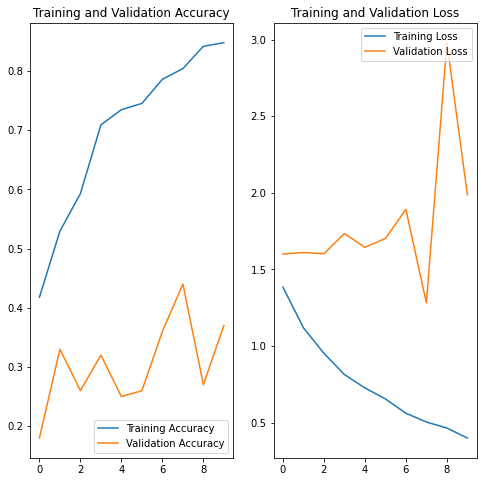

In [522]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(num_epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()